In [1]:
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

import itertools
import torch

from torch.utils.data import DataLoader, TensorDataset, Dataset
from copy import deepcopy

from wave_generator import WaveGen

from functools import partial

from ray import tune
from ray.train import Checkpoint, session
from ray.tune.schedulers import ASHAScheduler

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def torch_train_test_split(*tensors, split=.8):
    n_samples = tensors[0].shape[0]
    train_size = int(split * n_samples)
    test_size = n_samples - train_size
    rand_indices = torch.randperm(n_samples)
    train_indices, test_indices = torch.split(rand_indices, [train_size, test_size])
    assert train_indices.shape[0] == train_size, f'{train_indices.shape} != {train_size}'
    assert test_indices.shape[0] == n_samples - train_size, f'{test_indices.shape} != {n_samples - train_size}'

    data_tensors = list()
    for tensor in tensors:
        assert tensor.shape[0] == n_samples
        train_data = tensor[train_indices]
        test_data = tensor[test_indices]
        data_tensors.extend((train_data, test_data))
    return data_tensors
    
class TorchDataset(Dataset):
    def __init__(self, seq2seq_tensor, enc_window=120, dec_window=120):
        assert seq2seq_tensor.ndim == 2
        assert seq2seq_tensor.shape[0] > enc_window + dec_window, f'{seq2seq_tensor.shape} | {enc_window} | {dec_window}'
        self._data = seq2seq_tensor
        self.enc_window = enc_window
        self.dec_window = dec_window
        return
    
    @property
    def shape(self):
        return (self._data.shape[0] - (self.enc_window + self.dec_window), 1)

    def __len__(self):
        return self.shape[0]

    def __getitem__(self, index):
        enc_data = self._data[index - self.enc_window:index,:]
        dec_data = self._data[index:self.dec_window + index,:]
        return enc_data, dec_data

In [3]:
def get_data_load_fn(
    dataset_samples=100,
    size=2048,
    slopes=np.linspace(0.0001, .001, 100),
    n_periods=45,
    enc_window = 128,
    dec_window = 128,
    plot=True,
):
    arr_dict = dict()

    for slope in slopes:
        arr = WaveGen(size=size).linear_phase(n_periods=n_periods).cos().amp(2).t_noise(std=.01, dof=2).sample(n_samples=1).samples
        trend = np.exp(np.cumsum(np.log(np.random.normal(slope, .005, size=size) + 1))) - 1
        arr_dict[slope] = np.squeeze(arr + trend)

    if plot:
        for slope in np.random.choice(slopes, size=3):
            plt.figure(figsize=(15,5))
            plt.plot(arr_dict[slope].squeeze())
            plt.show()
    
    data = torch.from_numpy(np.stack(list(arr_dict.values()), axis=0))
    split_idx = int(data.shape[0]*.8)
    train_data = data[:split_idx]
    test_data = data[split_idx:]

    def data_load():
        train_dataset = TorchDataset(train_data.transpose(0,1), enc_window=enc_window, dec_window=dec_window)
        test_dataset = TorchDataset(test_data.transpose(0,1), enc_window=enc_window, dec_window=dec_window)
        return train_dataset, test_dataset

    return data_load()

In [4]:
class SineCNNLSTM(nn.Module):
    def __init__(
        self, 
        input_size,
        output_size=1,
        out_channels=16, 
        kernel_size=2, 
        stride=1, 
        drop=.4, 
        hidden_size=32,
        num_layers=1,
        **extra,
    ):
        super(SineCNNLSTM, self).__init__()
        
#         conv1_out_shape = (input_size - kernel_size) // stride + 1
#         pool_out_shape = (conv1_out_shape - pool_kernel) // pool_kernel + 1
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
        self.lstm = nn.LSTM(out_channels, hidden_size, num_layers=num_layers, dropout=drop)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.output = nn.Sigmoid()
        return
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        print(x.shape)
        x = self.lstm(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.output(x)
        return x

In [5]:
class SineCNNLSTM2(nn.Module):
    def __init__(
        self, 
        enc_window,
        dec_window,
        hidden_dim=64,
        output_dim=128,
        n_lstm_layers=3,
        kernel_size=3,
        stride=1,
        drop=.4,
    ):
        super(SineCNNLSTM, self).__init__()
        
        self.kernel_size = kernel_size
        self.stride = stride
        self.enc_window = enc_window
        self.dec_window = dec_window
        
        self.conv_in = self.single_conv(1, hidden_dim)
        self.conv_hidden = self.single_conv(hidden_dim, hidden_dim)
        self.conv_out = self.single_conv(hidden_dim, output_dim)
        self.gap = nn.AdaptiveAvgPool1d(1)
        
        self.lstm = nn.LSTM(output_dim, hidden_dim, num_layers=n_lstm_layers, dropout=drop)
        self.activation = nn.Sigmoid()

        self.criterion = nn.MSELoss()
        return
        
    def single_conv(self, in_channels, out_channels):
        layer = nn.Sequential(
            nn.Conv1d(
                in_channels, 
                out_channels, 
                kernel_size=self.kernel_size,
                stride=self.stride,
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
        )
        return layer

    def conv_forward(self, x):
        x = self.conv_in(x)
        x = self.conv_hidden(x)
        x = self.conv_out(x)
        print(x.shape)
        x = self.gap(x)
        print(x.shape)
        return x
    
    def forward(self, x):
        x = torch.cat([
            self.conv_forward(x[i:i+self.enc_window]) 
            for i 
            in range(x.shape[0] - self.enc_window)
        ])
        print('pre-lstm', x.shape)
        x = self.lstm(x)
        x = self.activation(x)
        print('post-lstm', x.shape)
        return x
    
    def loss(self, pred, label):
        label = label[i+self.enc_window:i+self.enc_window+self.dec_window]
        loss = self.criterion(pred, label)
        return loss

In [6]:
# https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html
def train_lstm(
    config,
    load_data_fn,
    load_model_fn,
    val_split=.8,
):
    model = load_model_fn(**config)
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=config['lr'])
    checkpoint = session.get_checkpoint()
    
    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        start_epoch = checkpoint_state['epoch']
        net.load_state_dict(checkpoint_state['net_state_dict'])
        optimizer.load_state_dict(checkpoint_state['optimizer_state_dict'])
    else:
        start_epoch = 0
    
    train_dataset, test_dataset = data_load_fn()
    k = int(len(train_dataset) * val_split)
    train_dataset, val_dataset = train_dataset[:k], train_dataset[k:]
    
    train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

    for epoch in range(start_epoch, 10):
        running_train_loss = 0.
        running_test_loss = 0.
        for (train_data, train_labels), (test_data, test_labels) in zip(train_dataloader, test_dataloader):
            for i in range(train_data.shape[0]):
                optimizer.zero_grad()
                train_output = model(train_data[i])

                train_loss = criterion(train_output, train_labels[i])       
                train_loss.backward()
                optimizer.step()
                running_train_loss += train_loss.item()

            for i in range(test_data.shape[0]):
                with torch.no_grad():
                    test_output = model(test_data[i])
                    test_loss = criterion(test_output, test_labels[i])
                    running_test_loss += test_loss.item()
                
            checkpoint_data = {
                'epoch' : epoch,
                'net_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
            }
            checkpoint = Checkpoint.from_dict(checkpoint_data)
            
            session.report(
                {'loss' : test_loss / test_data.shape[0]},
                checkpoint=checkpoint,
            )

    return

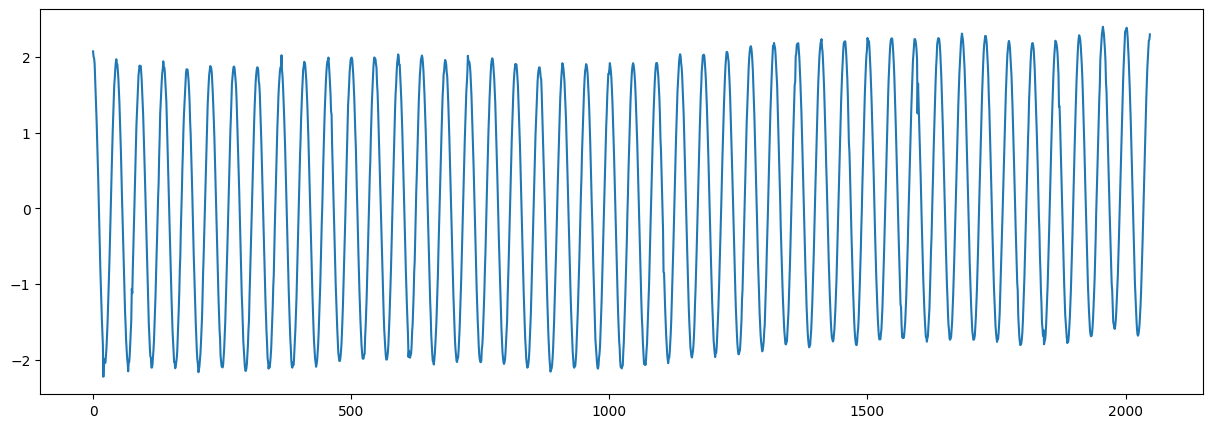

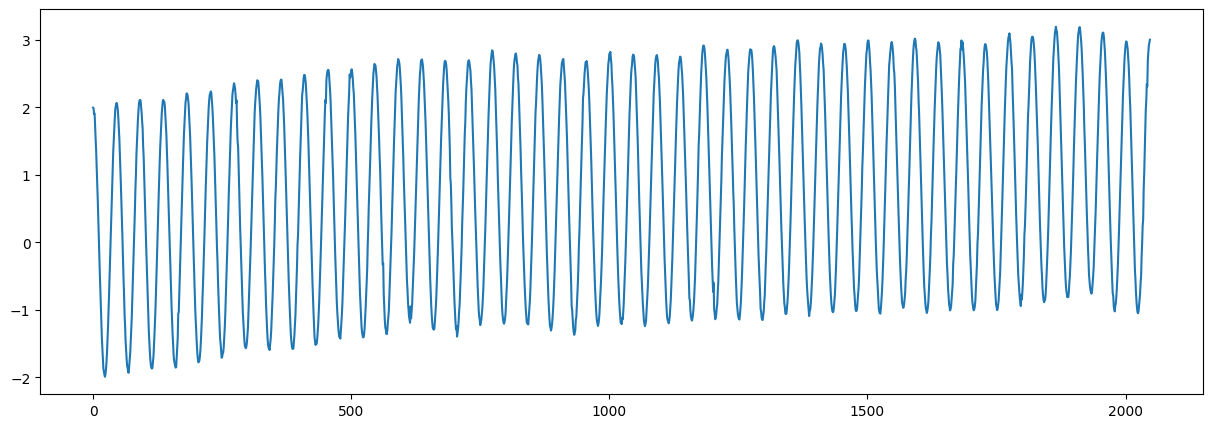

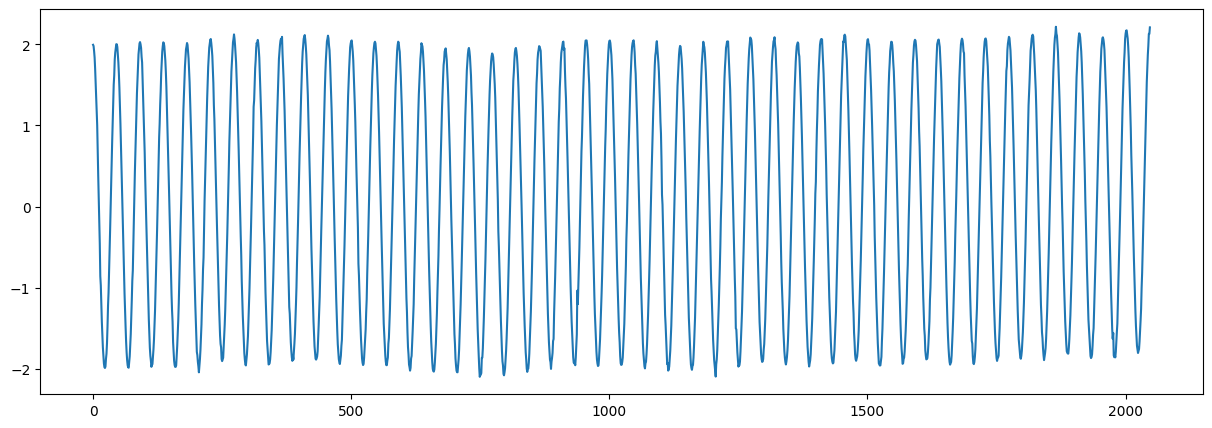

2023-11-21 23:12:28,401	ERROR services.py:1329 -- Failed to start the dashboard , return code 1
2023-11-21 23:12:28,402	ERROR services.py:1354 -- Error should be written to 'dashboard.log' or 'dashboard.err'. We are printing the last 20 lines for you. See 'https://docs.ray.io/en/master/ray-observability/ray-logging.html#logging-directory-structure' to find where the log file is.
2023-11-21 23:12:28,410	ERROR services.py:1398 -- 
The last 20 lines of C:\Users\Nick\AppData\Local\Temp\ray\session_2023-11-21_23-12-25_928680_10732\logs\dashboard.log (it contains the error message from the dashboard): 
  File "C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\dashboard\dashboard.py", line 75, in run
    await self.dashboard_head.run()
  File "C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\dashboard\head.py", line 325, in run
    modules = self._load_modules(self._modules_to_load)
  File "C:\Users\Nick\AppData\Local\Programs\Python\Python

ValueError: 'checkpoint_at_end' cannot be used with a function trainable. You should include one last call to `ray.train.report(metrics=..., checkpoint=...)` at the end of your training loop to get this behavior.

In [8]:
def hyperparameter_tune(input_size=128, output_size=128, cpus=4, num_samples=10, max_t=100, grace_period=2, reduction_factor=2):
    data_load_fn = get_data_load_fn(enc_window=input_size, dec_window=output_size)
    model_load_fn = lambda x : SineCNNLSTM(input_size, output_size, **x)
    
    config = {
        'out_channels' : [2,4,8,16],
        'kernel_size' : [2,8,24,48,96,256],
        'stride' : [1,2,4,8,24],
        'drop' : [.2, .4, .6],
        'hidden_size' : [8, 16, 32, 64],
        'num_layers' : [2,4,8],
    }

    scheduler = ASHAScheduler(
        metric='loss',
        mode='min',
        max_t=max_t,
        grace_period=grace_period,
        reduction_factor=reduction_factor,
    )

    result = tune.run(
        partial(train_lstm, data_load_fn, model_load_fn, val_split=.8),
        resources_per_trial={'cpu':cpus},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        checkpoint_at_end=True
    )
    
    best_trial = result.get_best_trial('loss', 'min', 'last')
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final test loss: {best_trial.last_result['loss']}")
    
    best_model = model_load_fn(
        out_channels=config['out_channels'], 
        kernel_size=config['kernel_size'], 
        stride=config['stride'],
        drop=config['drop'],
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
    )
    best_checkpoint_data = best_trial.checkpoint.to_air_checkpoint().to_dict()

    best_model.load_state_dict(best_checkpoint_data['net_state_dict'])
    return best_model

best_model = hyperparameter_tune()